In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from IPython.display import Image, display_png
import plotly.express as px
import cmasher as cmm

from epics import ca
ca.finalize_libca()

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:

%matplotlib inline

In [9]:
mpl.rcParams.update({'font.size': 12, 'text.usetex':False, 'svg.fonttype':'none'})

In [10]:
exp_type = 'peak_fwhm_nlpi'

In [11]:
#base_dir = Path(aps.__file__).parents[1]
#autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/")
data_base_dir = autoalign_dir / exp_type / 'all_motors_coma'
print(f'data base dir exists {data_base_dir.exists()}')


data base dir exists True


In [12]:
!ls {data_base_dir}

Screen Shot 2022-11-21 at 6.46.08 PM.png
peak_fwhm_nlpi_moo_100_2022-11-21_images
peak_fwhm_nlpi_moo_100_2022-11-21_steps
peak_fwhm_nlpi_moo_autofocusing.ini
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_18:31.gz
slits_078x0.12.png
slits_078x0.36.png


### peak_fwhm_150_2022-11-21

In [13]:
!ls {data_base_dir}

Screen Shot 2022-11-21 at 6.46.08 PM.png
peak_fwhm_nlpi_moo_100_2022-11-21_images
peak_fwhm_nlpi_moo_100_2022-11-21_steps
peak_fwhm_nlpi_moo_autofocusing.ini
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_18:31.gz
slits_078x0.12.png
slits_078x0.36.png


In [14]:
log_file = Path(data_base_dir / 'peak_fwhm_nlpi_moo_optimization_final_101_2022-11-21_18:31.gz')
log_file.exists()

True

In [15]:
hist_dir = Path(data_base_dir / 'peak_fwhm_nlpi_moo_100_2022-11-21_steps')
hist_dir.exists()

True

In [16]:
base_out_dir = Path('/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/peak_fwhm_nlpi')
base_out_dir.mkdir(exist_ok=True)

In [17]:
out_dir = base_out_dir / 'all_motors_coma_removed_bad_fwhm'
out_dir.mkdir(exist_ok=True)

In [18]:
study = analysis.create_study_from_trials(log_file, n_objectives=3)

[I 2023-06-11 15:48:19,819] A new study created in memory with name: no-name-01c7a334-b36b-4452-9d4a-0c4907054d00


Assuming minimization for all objectives.


In [19]:
n_steps = len(study.trials)

In [20]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

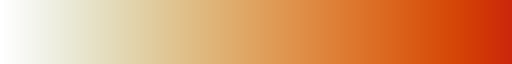

In [21]:
m2 = cmm.get_sub_cmap(cmm.sunburst_r, 0, 0.5)
m2

In [22]:
max_count = np.max([h.data_2D for h in hists])

In [23]:
max_count

35770.0

Trial values: peak_distance 8.078e-02 fwhm 1.404e+00 nlpi -9.772e+00
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.401485058027504, 'h_fwhm': 1.404000000000094, 'h_centroid': -0.0017463270150050725, 'h_peak': -0.07055766558591944, 'v_sigma': 0.47064040439042354, 'v_fwhm': 0.006502540054709183, 'v_centroid': 0.006134391857760907, 'v_peak': -0.03934036733098869, 'integral_intensity': 268.23379054618596, 'peak_intensity': 17541.2, 'gaussian_fit': {}}}


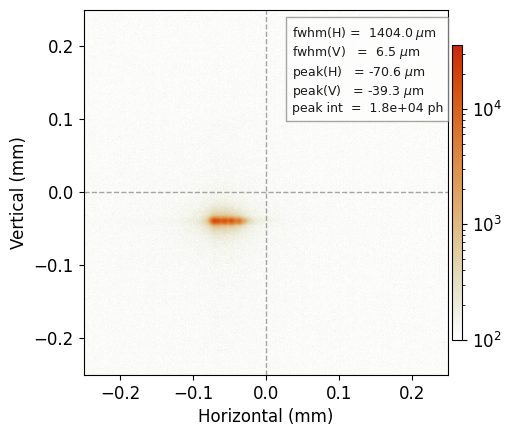

In [24]:
print(f"Trial values: peak_distance {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e} " +
     f"nlpi {study.trials[0].values[2]:4.3e}")
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)

dwd= dict(**study.trials[0].user_attrs["dw"]._DictionaryWrapper__dictionary)


plt.figure(figsize=[5,5], constrained_layout=True)
plt.pcolormesh(hists[0].hh, hists[0].vv, hists[0].data_2D.T[::-1], cmap=m2, 
               norm=mpl.colors.LogNorm(100, max_count), rasterized=True)
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
#plt.title("Initial")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
        fr"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
        fr"{'peak(H)':<9} = {dwd['h_peak'] * 1000: 2.1f} $\mu$m" + "\n"
        fr"{'peak(V)':<9} = {dwd['v_peak'] * 1000: 2.1f} $\mu$m" + "\n"
        fr"{'peak int':<9} = {dwd['peak_intensity']: 3.1e} ph")
ax.text(0.035, 0.11, text, color='black', alpha=0.9, fontsize=9,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
plt.savefig(f'{out_dir}/initial.svg', bbox_inches='tight', dpi=600)
plt.show()

In [25]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [26]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[75, 19, 94, 90, 51]
10 [0.013366714725420488, 1.1061743440157121, -10.462209701538086]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.4015682687156022, 'h_fwhm': 1.1061621120890042, 'h_centroid': -0.000659612372441748, 'h_peak': -0.012680870773506308, 'v_sigma': 0.4707828989055628, 'v_fwhm': 0.005202032043767346, 'v_centroid': 0.005484774901177436, 'v_peak': 0.004226651035560713, 'integral_intensity': 268.11322445422485, 'peak_intensity': 34968.75, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 1.1061743440157121


Trial number 2
Trial values: peak_distance 8.001e-02 fwhm 6.016e-01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.4014635151765894, 'h_fwhm': 0.6015284854099523, 'h_centroid': -0.0018713164604999832, 'h_peak': -0.07966188050023161, 'v_sigma': 0.4706640071846351, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.005477311809855445, 'v_peak': 0.007477921062915084, 'integral_intensity': 268.31064973836766, 'peak_intensity': 27315.0, 'gaussian_fit': {}}}


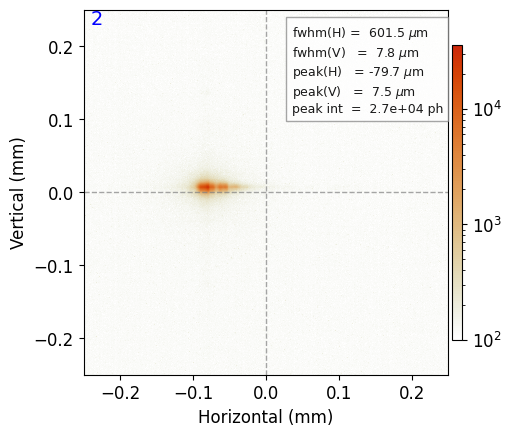

Trial number 7
Trial values: peak_distance 2.055e-01 fwhm 4.628e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.4017899275188471, 'h_fwhm': 0.013656322371469187, 'h_centroid': 0.0009079597562492991, 'h_peak': 0.11998054654932833, 'v_sigma': 0.47113395023883486, 'v_fwhm': 0.04421727237202244, 'v_centroid': 0.008034933090316915, 'v_peak': -0.16679015240328263, 'integral_intensity': 268.08976075013277, 'peak_intensity': 18217.111, 'gaussian_fit': {}}}


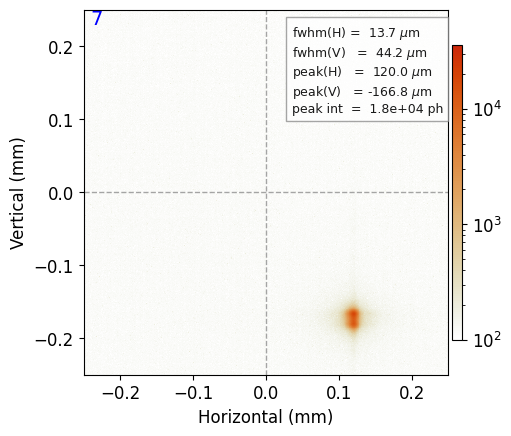

Trial number 10
Trial values: peak_distance 1.337e-02 fwhm 1.106e+00
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.4015682687156022, 'h_fwhm': 1.1061621120890042, 'h_centroid': -0.000659612372441748, 'h_peak': -0.012680870773506308, 'v_sigma': 0.4707828989055628, 'v_fwhm': 0.005202032043767346, 'v_centroid': 0.005484774901177436, 'v_peak': 0.004226651035560713, 'integral_intensity': 268.11322445422485, 'peak_intensity': 34968.75, 'gaussian_fit': {}}}


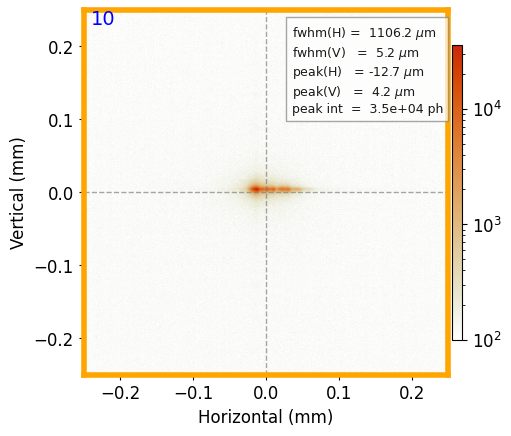

Trial number 13
Trial values: peak_distance 9.568e-03 fwhm 4.197e-01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.4015845777835324, 'h_fwhm': 0.41944418712369647, 'h_centroid': -0.0006085651038972573, 'h_peak': -0.0016257526632700889, 'v_sigma': 0.4708037963479019, 'v_fwhm': 0.015606096131302039, 'v_centroid': 0.005725907518988743, 'v_peak': -0.009428683079327914, 'integral_intensity': 268.11008513510757, 'peak_intensity': 17398.916, 'gaussian_fit': {}}}


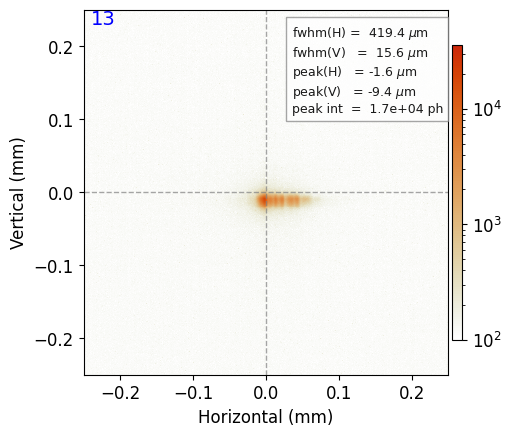

Trial number 16
Trial values: peak_distance 2.476e-03 fwhm 1.404e+00
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.40167248528570104, 'h_fwhm': 1.404000000000094, 'h_centroid': -0.0006841731177621435, 'h_peak': 0.0009754515979620237, 'v_sigma': 0.4707916947129939, 'v_fwhm': 0.020157874169598466, 'v_centroid': 0.005590158068646628, 'v_peak': -0.0022758890191481784, 'integral_intensity': 268.14740514426904, 'peak_intensity': 12473.429, 'gaussian_fit': {}}}


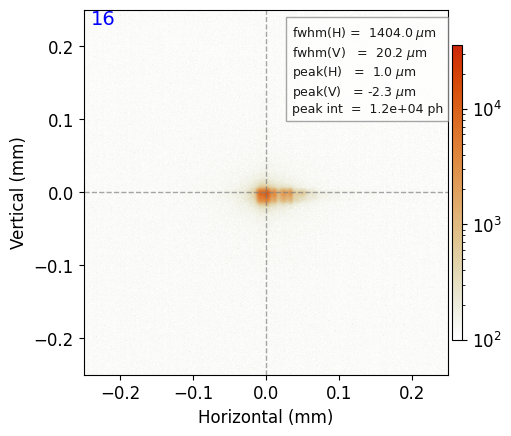

In [30]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    
    
    dwd= dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    

    plt.figure(figsize=[5,5], constrained_layout=True)
    plt.pcolormesh(hists[t.number].hh, hists[t.number].vv, hists[t.number].data_2D.T[::-1], cmap=m2, 
                   norm=mpl.colors.LogNorm(100, max_count), rasterized=True)
    plt.xlim(-0.25,0.25)
    plt.ylim(-0.25,0.25)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    #plt.title(t.number)
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')

    text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'peak(H)':<9} = {dwd['h_peak'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'peak(V)':<9} = {dwd['v_peak'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'peak int':<9} = {dwd['peak_intensity']: 3.1e} ph")
    #ax.text(0.035, 0.11, text, color='black', alpha=0.9, fontsize=9,
    ax.text(0.035 , 0.11, text, color='black', alpha=0.9, fontsize=9,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
    plt.text(-0.24, 0.23, t.number, fontsize=14, color='blue')
    plt.savefig(f'{out_dir}/pareto_{t.number}.svg', bbox_inches='tight', dpi=600)
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color('orange')
    plt.show()

In [31]:
study.best_trials[0].values

[0.08001208976308749, 0.6015790939840796, -10.215190887451172]

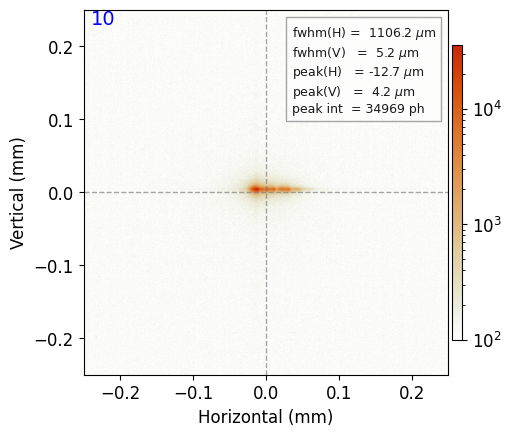

In [32]:

tnum = nash_trial.number
dwd = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)

hist = hists[tnum]
plt.figure(figsize=[5,5], constrained_layout=True)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T[::-1], cmap=m2, 
               norm=mpl.colors.LogNorm(100, max_count), rasterized=True)
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
#plt.title(t.number)
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')


text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
             fr"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph")
ax.text(0.035, 0.11, text, color='black', alpha=0.9, fontsize=9,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
plt.text(-0.24, 0.23, tnum, fontsize=14, color='blue')
plt.savefig(f'{out_dir}/pareto_hh.svg', bbox_inches='tight', dpi=600)
plt.show()

In [33]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ['peak_distance', 'fwhm', 'nlpi'])

In [34]:
pareto_df

,number,peak_distance,fwhm,nlpi,h_peak,v_peak,h_fwhm,v_fwhm,peak_intensity
2,2,0.080012,0.601579,-10.215191,-0.079662,0.007478,0.601528,0.007803,27315.000000
7,7,0.205461,0.046278,-9.810117,0.119981,-0.166790,0.013656,0.044217,18217.111328
10,10,0.013367,1.106174,-10.462210,-0.012681,0.004227,1.106162,0.005202,34968.750000
13,13,0.009568,0.419734,-9.764163,-0.001626,-0.009429,0.419444,0.015606,17398.916016
16,16,0.002476,1.404145,-9.431356,0.000975,-0.002276,1.404000,0.020158,12473.428711


In [35]:
c1 = [nash_trial.number]
c2 = [t.number for t in study.best_trials if t.number not in c1]
c3 = [n for n in range(len(hists)) if n not in c1 and n not in c2]


In [36]:
c2

[2, 7, 13, 16]

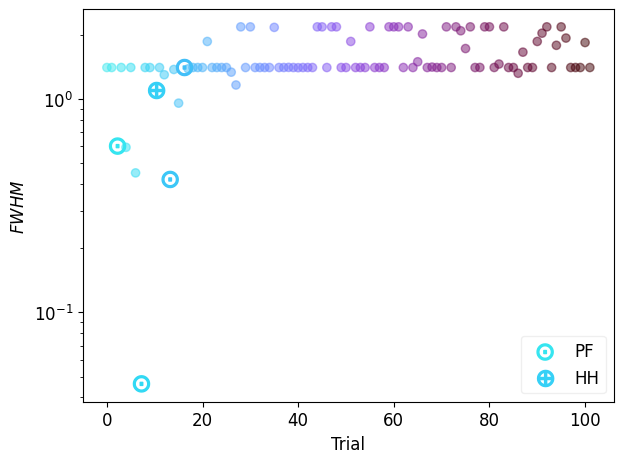

In [37]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values



plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[1] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.gem_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.gem_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.gem_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='HH')

plt.xlabel('Trial')
plt.ylabel('$FWHM$')
plt.yscale('log')
#for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
#plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
#plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

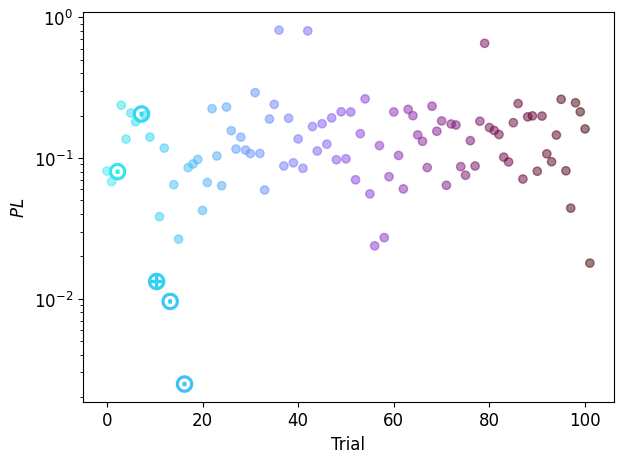

In [38]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.gem_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.gem_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.gem_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='HH')

plt.xlabel('Trial')
plt.ylabel('$PL$')
plt.yscale('log')
#for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
#plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
#plt.axvline(nash_trial.number, color='orange', label='HH')
plt.tight_layout()
plt.show()

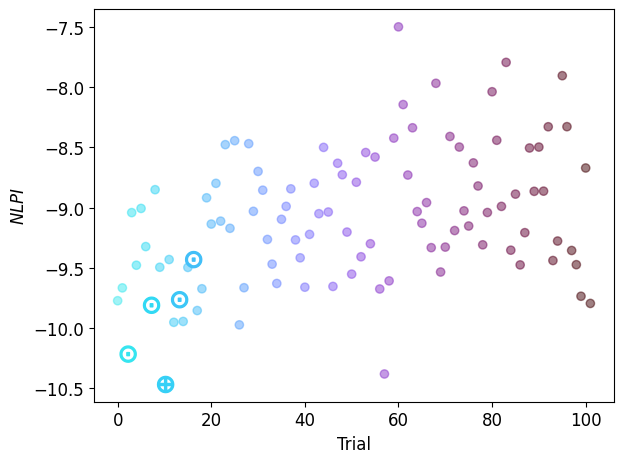

In [39]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.gem_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.gem_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.gem_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='HH')

plt.xlabel('Trial')
plt.ylabel('$NLPI$')
plt.tight_layout()
plt.show()

In [40]:
ground = {'peak_distance': 2.244e-02, 'fwhm': 1.985e-02, 'nlpi': -1.081e+01}

4.464714677148749 4.326330684196638


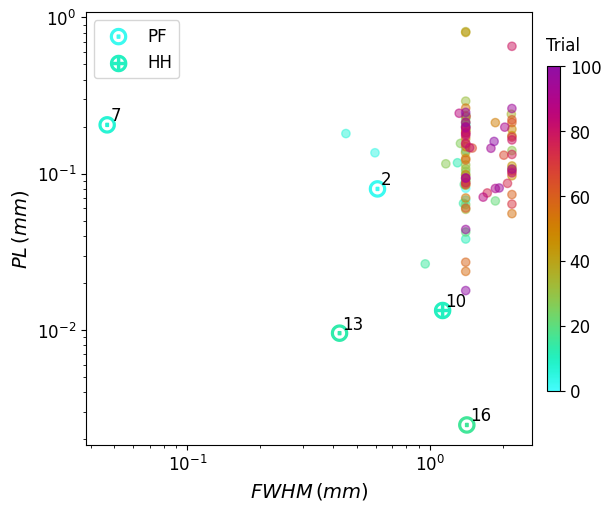

In [41]:

x = np.array([t.values[1] for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

fig = plt.figure(figsize=[6,5],constrained_layout=True)
plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.tropical_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.tropical_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.tropical_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='HH')

for t in study.best_trials:
    plt.annotate(t.number, xy=(x[t.number], y[t.number]), xytext=(3, 3), textcoords='offset points')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$FWHM\,(mm)$', fontsize=14)
plt.ylabel('$PL\,(mm)$', fontsize=14)
cbar = plt.colorbar(pad=0.03, aspect=25, shrink=0.75, location='right')
#cbar.ax.set_ylabel('Trial')
cbar.ax.text(-0.1, 105.0,'Trial')
#cbar.ax.set_xlabel('Trial')#, fontsize=14)

#plt.scatter(ground['fwhm'], ground['peak_distance'], color='red', marker='*', s=175, label='M')
plt.legend(loc='best')
r = fig.canvas.get_renderer()
ax = plt.gca()

fig.execute_constrained_layout()
print(ax.bbox.width / fig.dpi, ax.bbox.height / fig.dpi)
plt.savefig(f'{out_dir}/pareto_fwhm_pl.svg', bbox_inches='tight', dpi=600)
plt.show()

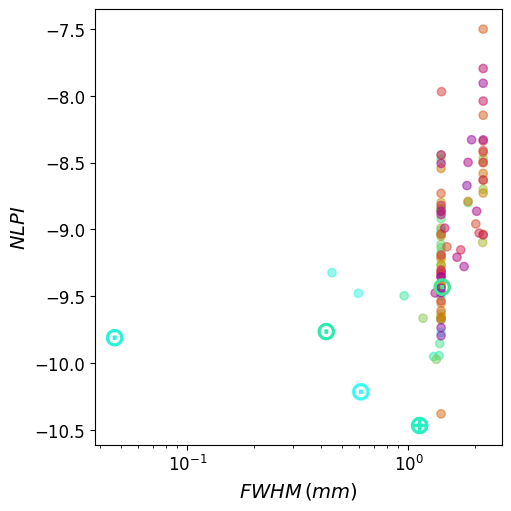

In [42]:
plt.figure(figsize=[5, 5],constrained_layout=True)
x = np.array([t.values[1] for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.tropical_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.tropical_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.tropical_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='HH')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$FWHM\, (mm)$', fontsize=14)
plt.ylabel('$NLPI$', fontsize=14)

#plt.scatter(ground['fwhm'], ground['nlpi'], color='red', marker='*', s=175, label='M')
#plt.legend(loc='best')
#plt.tight_layout()

plt.savefig(f'{out_dir}/pareto_fwhm_nlpi.svg', bbox_inches='tight', dpi=600)
plt.show()

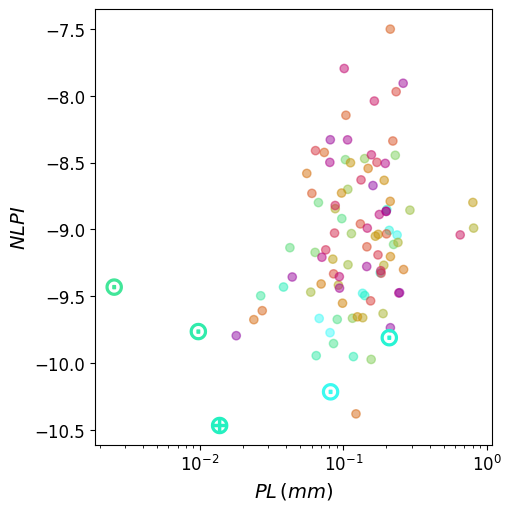

In [43]:
plt.figure(figsize=[5, 5],constrained_layout=True)
x = np.array([t.values[0] for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.tropical_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.tropical_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.tropical_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='HH')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$PL\,(mm)$', fontsize=14)
plt.ylabel('$NLPI$', fontsize=14)

#plt.scatter(ground['peak_distance'], ground['nlpi'], color='red', marker='*', s=175, label='M')
#plt.legend(loc='best')
#plt.tight_layout()

plt.savefig(f'{out_dir}/pareto_pl_nlpi.svg', bbox_inches='tight', dpi=600)
plt.show()

#### The remaining part is just testing how lwsi with thresholding performs in selecting the structures. This is for my own satisfaction. - SK

In [25]:
isums = []
wsums_no_thres = []
wsums_thres = []
for h in hists:
    isum1, wsum1 = analysis.calculate_weighted_sum(h, threshold=0)
    isum2, wsum2 = analysis.calculate_weighted_sum(h)
    isums.append((isum1, isum2))
    wsums_no_thres.append(wsum1)
    wsums_thres.append(wsum2)
isums = np.array(isums)
wsums_no_thres = np.array(wsums_no_thres)
wsums_thres = np.array(wsums_thres)
                      

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_49136/214102518.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),


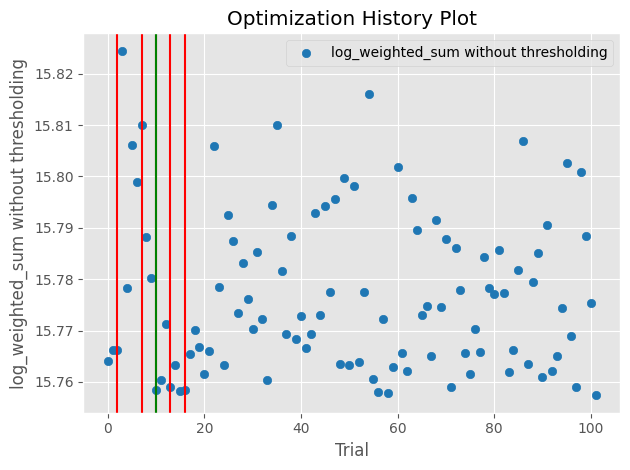

In [26]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),
                                                          target_name="log_weighted_sum without thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_49136/2958963105.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),


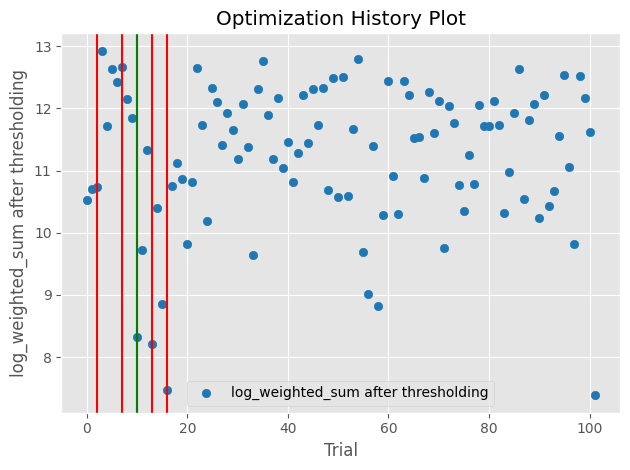

In [27]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),
                                                          target_name="log_weighted_sum after thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [28]:
test_val_fns = [lambda t: t.values[0], lambda t: t.values[2], lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, study.directions, values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1, 1], test_val_fns)
print(np.argmax(domins))

10


10 [0.013366714725420488, -10.462209701538086, 8.326755106873964]


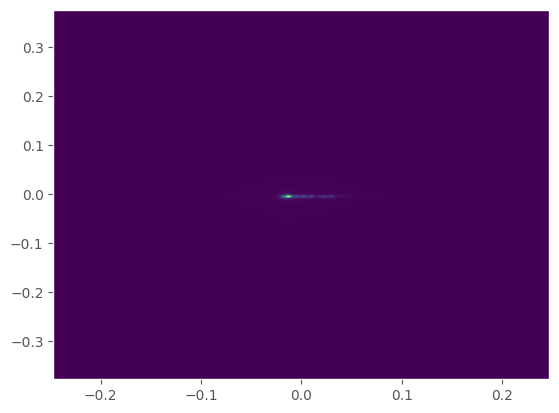

13 [0.009567817741394027, -9.76416301727295, 8.211130601529655]


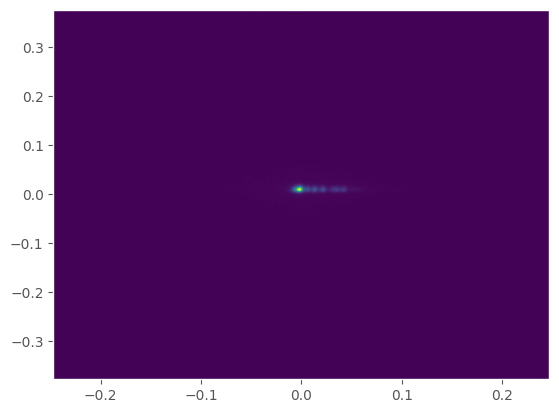

16 [0.0024761212909399093, -9.431356430053711, 7.467094804943765]


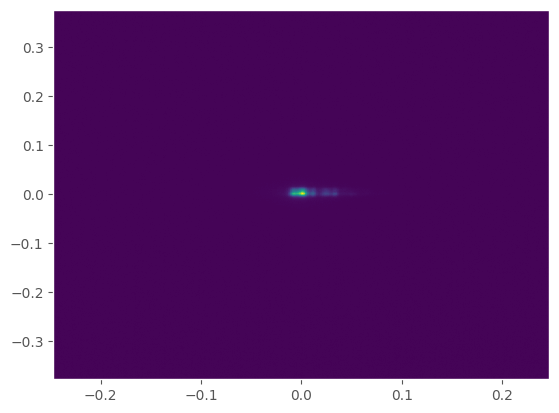

101 [0.017909766650565845, -9.794880867004395, 7.381433088986161]


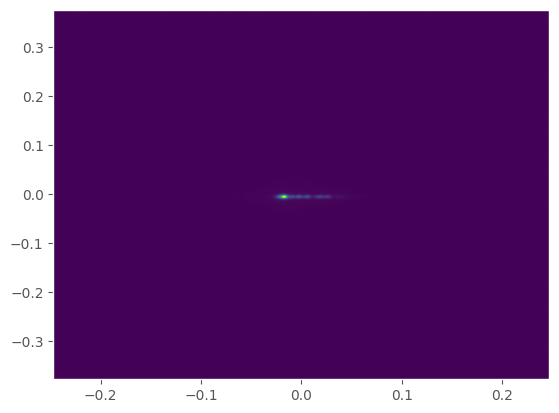

In [29]:
for t in test_pareto:
    print(t.number, test_values[t.number])
    hdata = hists[t.number]
    
    plt.pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T)
    plt.show()

In [30]:
test_val_fns = [lambda t: t.values[0], lambda t: opt_common._get_fwhm_from_dw(t.user_attrs['dw']), lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1, 1], values_fns=test_val_fns)

domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1, 1], test_val_fns)
print(np.argmax(domins), domins[np.argmax(domins)])

13 98
